# Cell 1 — Clean install & GPU check (Colab-safe)

In [3]:
!nvidia-smi -L
!pip -q uninstall -y cudf-cu12 dask-cudf-cu12 cuml-cu12 pylibcudf-cu12 rmm-cu12 ucx-py ucxx rapids-dask-dependency || true

!pip -q install -U pandas==2.2.2 pyarrow==21.0.0
!pip -q install -U transformers datasets accelerate scikit-learn

GPU 0: Tesla T4 (UUID: GPU-6a7b8b13-34fe-caad-3cb0-1f31e748c58c)


# Cell 2 — (Optional) Mount Drive

In [4]:
from google.colab import drive
USE_DRIVE = False
drive.mount('/content/drive')
if USE_DRIVE:
    SAVE_DIR = "/content/drive/MyDrive/baitbuster_two_stage"
else:
    SAVE_DIR = "/content/baitbuster_two_stage"

import os
os.makedirs(SAVE_DIR, exist_ok=True)
print("Saving to:", SAVE_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saving to: /content/baitbuster_two_stage


# Cell 3 — Load dataset

In [5]:
import pandas as pd, os

CSV_PATH     = "/content/drive/MyDrive/Dataset/BaitBuster-Bangla_253070_18c_HL10k_AIL.csv"
PARQUET_PATH = "/content/drive/MyDrive/Dataset/BaitBuster-Bangla_253070_18c_HL10k_AIL.parquet"
XLSX_PATH    = "/content/drive/MyDrive/Dataset/BaitBuster-Bangla_253070_18c_HL10k_AIL.xlsx"

if   os.path.exists(CSV_PATH):     df_all = pd.read_csv(CSV_PATH)
elif os.path.exists(PARQUET_PATH): df_all = pd.read_parquet(PARQUET_PATH)
elif os.path.exists(XLSX_PATH):    df_all = pd.read_excel(XLSX_PATH)
else: raise FileNotFoundError("Upload dataset and update the paths above.")

print("Columns:", list(df_all.columns)[:30])
print("Rows:", len(df_all))

Columns: ['channel_id', 'channel_name', 'channel_url', 'video_id', 'publishedAt', 'title', 'title_debiased', 'description', 'description_debiased', 'url', 'viewCount', 'commentCount', 'likeCount', 'dislikeCount', 'thumbnail', 'auto_labeled', 'human_labeled', 'ai_labeled']
Rows: 253070


# Cell 4 — Labels, text cleaning, engagement features


In [6]:
import numpy as np
import pandas as pd

TITLE_COL = "title_debiased" if "title_debiased" in df_all.columns else "title"
DESC_COL  = "description_debiased" if "description_debiased" in df_all.columns else "description"

assert TITLE_COL in df_all.columns, f"Missing {TITLE_COL}"
if DESC_COL not in df_all.columns:
    df_all[DESC_COL] = ""

def norm_label(s):
    if pd.isna(s): return None
    s = str(s).strip().lower()
    mapping = {
        "not_clickbait":"not clickbait", "non-clickbait":"not clickbait",
        "non_clickbait":"not clickbait", "notclickbait":"not clickbait",
        "click bait":"clickbait", "yes":"clickbait", "no":"not clickbait",
        "1":"clickbait", "0":"not clickbait"
    }
    return mapping.get(s, s if s in ["clickbait","not clickbait"] else None)

def choose_label_and_source(row):
    for col, src in [("human_labeled","human"), ("ai_labeled","ai"), ("auto_labeled","auto")]:
        if col in row.index and pd.notna(row[col]):
            lab = norm_label(row[col])
            if lab in ["clickbait","not clickbait"]:
                return lab, src
    return None, None

labs, srcs = [], []
for _, r in df_all.iterrows():
    l, s = choose_label_and_source(r)
    labs.append(l); srcs.append(s)

df_all["label_str"] = labs
df_all["label_source"] = srcs
df_all = df_all[df_all["label_str"].isin(["clickbait","not clickbait"])].copy()
df_all["label"] = (df_all["label_str"] == "clickbait").astype(int)

def _clean_text(s):
    if pd.isna(s): return ""
    return str(s).strip()

df_all[TITLE_COL] = df_all[TITLE_COL].apply(_clean_text)
df_all[DESC_COL]  = df_all[DESC_COL].apply(_clean_text)
df_all = df_all[df_all[TITLE_COL].ne("")].copy()

print("Usable rows:", len(df_all))
print("Label balance 0/1:", np.bincount(df_all["label"]))
print(df_all["label_source"].value_counts(dropna=False).to_frame("count"))

for c in ["viewCount", "likeCount", "commentCount", "dislikeCount"]:
    if c not in df_all.columns:
        df_all[c] = 0

for c in ["viewCount", "likeCount", "commentCount", "dislikeCount"]:
    df_all[c] = pd.to_numeric(df_all[c], errors="coerce").fillna(0)

for c in ["viewCount", "likeCount", "commentCount", "dislikeCount"]:
    df_all[f"log1p_{c}"] = np.log1p(df_all[c])

df_all["like_ratio"]   = df_all["likeCount"] / (df_all["likeCount"] + df_all["dislikeCount"] + 1.0)
df_all["comment_rate"] = df_all["commentCount"] / (df_all["viewCount"] + 1.0)

NUM_FEATS = [
    "log1p_viewCount", "log1p_likeCount", "log1p_commentCount", "log1p_dislikeCount",
    "like_ratio", "comment_rate"
]
print("Numeric features:", NUM_FEATS)

Usable rows: 253070
Label balance 0/1: [208024  45046]
               count
label_source        
ai            243070
human          10000
Numeric features: ['log1p_viewCount', 'log1p_likeCount', 'log1p_commentCount', 'log1p_dislikeCount', 'like_ratio', 'comment_rate']


# Cell 5 — Human-only splits + stage pools + scaler (fit on Stage-1 only)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

is_human = (df_all["label_source"] == "human")
df_human = df_all[is_human].copy()
assert len(df_human) > 0, "No human-labeled rows found."

idx = np.arange(len(df_human))
h_tr_idx, h_tmp = train_test_split(idx, test_size=0.30, stratify=df_human["label"].values, random_state=42)
h_va_idx, h_te_idx = train_test_split(h_tmp, test_size=0.50, stratify=df_human["label"].values[h_tmp], random_state=42)

df_h_tr = df_human.iloc[h_tr_idx].copy()
df_h_va = df_human.iloc[h_va_idx].copy()
df_h_te = df_human.iloc[h_te_idx].copy()

print("Human splits sizes:", len(df_h_tr), len(df_h_va), len(df_h_te))

human_valtest_ids = set(df_h_va.index.tolist() + df_h_te.index.tolist())
mask_stage1 = ~df_all.index.isin(human_valtest_ids)

df_stage1 = df_all[mask_stage1].copy()     # Stage-1: human-train + AI + auto
df_stage2 = df_h_tr.copy()                  # Stage-2: human-train
df_eval_val = df_h_va.copy()                # Validation on human-val
df_eval_test = df_h_te.copy()               # Final test on human-test

# Source-based sample weights (Stage-1 only)
weight_map = {"human": 1.0, "ai": 0.7, "auto": 0.5}
df_stage1["sample_weight"] = df_stage1["label_source"].map(weight_map).fillna(0.5).astype("float32")

print("\nStage-1 size:", len(df_stage1), "(by source)")
print(df_stage1["label_source"].value_counts())
print("\nStage-2 (human-train) size:", len(df_stage2))
print("\nEval val/test sizes:", len(df_eval_val), len(df_eval_test))

# ----- Fit scaler on Stage-1 only (no leakage) -----
scaler = StandardScaler()
X1 = scaler.fit_transform(df_stage1[NUM_FEATS].values.astype("float32"))
X2 = scaler.transform(df_stage2[NUM_FEATS].values.astype("float32"))
XV = scaler.transform(df_eval_val[NUM_FEATS].values.astype("float32"))
XT = scaler.transform(df_eval_test[NUM_FEATS].values.astype("float32"))

# Stash arrays for dataset builders
df_stage1["_eng_feats_np"]   = list(X1)
df_stage2["_eng_feats_np"]   = list(X2)
df_eval_val["_eng_feats_np"] = list(XV)
df_eval_test["_eng_feats_np"] = list(XT)

Human splits sizes: 7000 1500 1500

Stage-1 size: 250070 (by source)
label_source
ai       243070
human      7000
Name: count, dtype: int64

Stage-2 (human-train) size: 7000

Eval val/test sizes: 1500 1500


# Cell 6 — Tokenize (title + description) and attach numeric features

In [8]:
# ✅ Memory-lean Cell 6 — build HF datasets without np.stack + drop raw text after tokenization
from datasets import Dataset
from transformers import AutoTokenizer
import numpy as np

MODEL_NAME = "csebuetnlp/banglabert"  # or "sagorsarker/bangla-bert-base"
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

MAX_LEN = 128            # start with 128 to reduce memory; try 192/256 later if VRAM allows
TRUNC_POLICY = "only_second"  # keep title; truncate description

def to_ds_memlean(df, include_weights=False):
    # 1) Build a light dict — keep only what we need, and store eng feats as float16 lists (saves ~50% RAM)
    data = {
        "title": df[TITLE_COL].astype(str).tolist(),
        "desc":  df[DESC_COL].astype(str).tolist(),
        "labels": df["label"].astype("int64").tolist(),
        "eng_feats": [np.asarray(x, dtype="float16").tolist() for x in df["_eng_feats_np"].values],
    }
    if include_weights and "sample_weight" in df.columns:
        data["sample_weight"] = df["sample_weight"].astype("float32").tolist()

    ds = Dataset.from_dict(data)

    # 2) Tokenize in batches and DROP raw text columns to free RAM
    def tok_fn(batch):
        enc = tok(
            batch["title"],
            batch["desc"],
            truncation=TRUNC_POLICY,
            padding="max_length",
            max_length=MAX_LEN
        )
        batch.update(enc)
        return batch

    # tokenization in chunks keeps peak RAM lower; adjust batch_size if needed
    ds = ds.map(tok_fn, batched=True, batch_size=1024, remove_columns=["title", "desc"])

    # 3) Set format to torch only for the columns we actually need at training time
    torch_cols = ["input_ids", "attention_mask", "labels", "eng_feats"]
    if "token_type_ids" in ds.column_names:
        torch_cols.append("token_type_ids")
    if include_weights and "sample_weight" in ds.column_names:
        torch_cols.append("sample_weight")

    ds = ds.with_format("torch", columns=torch_cols)
    return ds

# Build all splits (Stage-1 includes weights; Stage-2/val/test don't)
ds_stage1 = to_ds_memlean(df_stage1, include_weights=True)
ds_stage2 = to_ds_memlean(df_stage2, include_weights=False)
ds_val    = to_ds_memlean(df_eval_val, include_weights=False)
ds_test   = to_ds_memlean(df_eval_test, include_weights=False)

len(ds_stage1), len(ds_stage2), len(ds_val), len(ds_test)

Map:   0%|          | 0/250070 [00:00<?, ? examples/s]

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

(250070, 7000, 1500, 1500)

# Cell 7 — Metrics + Weighted Trainer

In [9]:
import torch, torch.nn as nn
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    return {
        "accuracy": float(accuracy_score(labels, preds)),
        "f1_macro": float(f1_score(labels, preds, average="macro")),
        "f1_micro": float(f1_score(labels, preds, average="micro")),
        "kappa":    float(cohen_kappa_score(labels, preds)),
    }

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        weights = inputs.pop("sample_weight", None)

        outputs = model(**inputs, labels=labels)
        logits = outputs.logits

        ce = nn.CrossEntropyLoss(reduction="none")(logits, labels)
        if weights is not None:
            weights = weights.to(ce.device).view(-1)
            loss = (ce * weights).sum() / (weights.sum() + 1e-8)
        else:
            loss = ce.mean()
        return (loss, outputs) if return_outputs else loss

# Cell 8 — Custom model: BanglaBERT + small MLP for numeric feats

In [10]:
import torch.nn as nn
from transformers import AutoModel, AutoConfig
from transformers.modeling_outputs import SequenceClassifierOutput

class BertWithNumeric(nn.Module):
    def __init__(self, model_name: str, num_labels: int = 2, num_numeric: int = 6):
        super().__init__()
        self.config = AutoConfig.from_pretrained(model_name)
        self.bert = AutoModel.from_pretrained(model_name, config=self.config)
        hidden = self.config.hidden_size

        self.num_proj = nn.Sequential(
            nn.Linear(num_numeric, 32),
            nn.ReLU(),
            nn.LayerNorm(32)
        )

        self.dropout = nn.Dropout(getattr(self.config, "hidden_dropout_prob", 0.1))
        self.classifier = nn.Linear(hidden + 32, num_labels)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        eng_feats=None,
        labels=None,
        **kwargs
    ):
        bert_out = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        pooled = bert_out.last_hidden_state[:, 0, :]  # CLS

        if eng_feats is None:
            num_emb = torch.zeros((pooled.size(0), 32), device=pooled.device)
        else:
            num_emb = self.num_proj(eng_feats)

        x = torch.cat([pooled, num_emb], dim=1)
        x = self.dropout(x)
        logits = self.classifier(x)

        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)

        return SequenceClassifierOutput(loss=loss, logits=logits)

# Cell 9 — Stage-1 training (pretrain on broad pool)

In [11]:
import os, torch

stage1_model = BertWithNumeric(MODEL_NAME, num_labels=2, num_numeric=len(NUM_FEATS))

# Some transformers versions renamed eval args; try both
try:
    stage1_args = TrainingArguments(
        output_dir=os.path.join(SAVE_DIR, "stage1_all"),
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        num_train_epochs=2,      # 2–3 is enough for pretraining
        weight_decay=0.01,
        evaluation_strategy="no",
        save_strategy="epoch",
        logging_steps=100,
        fp16=torch.cuda.is_available(),
        seed=42,
        report_to=[]
    )
except TypeError:
    stage1_args = TrainingArguments(
        output_dir=os.path.join(SAVE_DIR, "stage1_all"),
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        num_train_epochs=2,
        weight_decay=0.01,
        eval_strategy="no",
        save_strategy="epoch",
        logging_steps=100,
        fp16=torch.cuda.is_available(),
        seed=42,
        report_to=[]
    )

stage1_trainer = WeightedTrainer(
    model=stage1_model,
    args=stage1_args,
    train_dataset=ds_stage1,   # has sample_weight + eng_feats
)
stage1_trainer.train()

stage1_ckpt = os.path.join(SAVE_DIR, "stage1_all_best")
stage1_trainer.save_model(stage1_ckpt)
print("Stage-1 checkpoint saved to:", stage1_ckpt)

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

Step,Training Loss
100,0.377500
200,0.302000
300,0.270100
400,0.267300
500,0.244100
600,0.228600
700,0.208000
800,0.222000
900,0.198100
1000,0.207400


Stage-1 checkpoint saved to: /content/baitbuster_two_stage/stage1_all_best


# Cell 10 — Stage-2 fine-tuning (human-train) with early stopping on human-val

In [17]:
import os, torch
from safetensors.torch import load_file as load_sft  # safe even if file not present

stage2_model = BertWithNumeric(MODEL_NAME, num_labels=2, num_numeric=len(NUM_FEATS))

ckpt_dir = stage1_ckpt  # must match the path printed in Cell 9
bin_path = os.path.join(ckpt_dir, "pytorch_model.bin")
sft_path = os.path.join(ckpt_dir, "model.safetensors")
pt_path  = os.path.join(ckpt_dir, "stage1_state_dict.pt")

loaded = False
if os.path.exists(pt_path):
    state = torch.load(pt_path, map_location="cpu")
    stage2_model.load_state_dict(state, strict=False); loaded = True
elif os.path.exists(bin_path):
    state = torch.load(bin_path, map_location="cpu")
    stage2_model.load_state_dict(state, strict=False); loaded = True
elif os.path.exists(sft_path):
    state = load_sft(sft_path)
    stage2_model.load_state_dict(state, strict=False); loaded = True

print("Loaded Stage-1 weights:", loaded)
if not loaded:
    print("⚠️ Could not find Stage-1 weights; training Stage-2 from fresh init.")

try:
    stage2_args = TrainingArguments(
        output_dir=os.path.join(SAVE_DIR, "stage2_human"),
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        num_train_epochs=4,            # 3–5 typically good
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        logging_steps=100,
        fp16=torch.cuda.is_available(),
        seed=42,
        report_to=[]
    )
except TypeError:
    stage2_args = TrainingArguments(
        output_dir=os.path.join(SAVE_DIR, "stage2_human"),
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        num_train_epochs=4,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        logging_steps=100,
        fp16=torch.cuda.is_available(),
        seed=42,
        report_to=[]
    )

stage2_trainer = Trainer(
    model=stage2_model,
    args=stage2_args,
    train_dataset=ds_stage2,   # human-train only
    eval_dataset=ds_val,       # human-val
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

stage2_trainer.train()

stage2_ckpt = os.path.join(SAVE_DIR, "stage2_human_best")
stage2_trainer.save_model(stage2_ckpt)
print("Stage-2 best checkpoint saved to:", stage2_ckpt)

Loaded Stage-1 weights: True


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Micro,Kappa
1,0.020300,0.019096,0.995333,0.995248,0.995333,0.990496
2,0.005700,0.015789,0.996000,0.995928,0.996000,0.991855
3,0.003300,0.020012,0.996000,0.995928,0.996000,0.991855
4,0.001800,0.017436,0.996000,0.995928,0.996000,0.991855


Stage-2 best checkpoint saved to: /content/baitbuster_two_stage/stage2_human_best


# **Cell 11** - Final evaluation on human-test + save metrics

In [18]:
from pprint import pprint
from sklearn.metrics import confusion_matrix, classification_report
import json, pandas as pd, os

raw_val  = stage2_trainer.predict(ds_val)
raw_test = stage2_trainer.predict(ds_test)

print("=== HUMAN-VAL METRICS ===")
val_metrics = compute_metrics((raw_val.predictions, raw_val.label_ids))
pprint(val_metrics)

print("\n=== HUMAN-TEST METRICS ===")
test_metrics = compute_metrics((raw_test.predictions, raw_test.label_ids))
pprint(test_metrics)

y_pred = raw_test.predictions.argmax(axis=1)
print("\nConfusion matrix [rows=true, cols=pred] (0,1):\n", confusion_matrix(raw_test.label_ids, y_pred))
print("\nClassification report:\n", classification_report(raw_test.label_ids, y_pred, digits=4))

pd.DataFrame([val_metrics]).to_csv(os.path.join(SAVE_DIR, "val_metrics.csv"), index=False)
pd.DataFrame([test_metrics]).to_csv(os.path.join(SAVE_DIR, "final_human_test_metrics.csv"), index=False)
with open(os.path.join(SAVE_DIR, "final_human_test_metrics.json"), "w") as f:
    json.dump(test_metrics, f, indent=2)

=== HUMAN-VAL METRICS ===
{'accuracy': 0.996,
 'f1_macro': 0.9959276018099548,
 'f1_micro': 0.996,
 'kappa': 0.9918553362931645}

=== HUMAN-TEST METRICS ===
{'accuracy': 0.9946666666666667,
 'f1_macro': 0.9945740247713856,
 'f1_micro': 0.9946666666666667,
 'kappa': 0.989148128052089}

Confusion matrix [rows=true, cols=pred] (0,1):
 [[648   6]
 [  2 844]]

Classification report:
               precision    recall  f1-score   support

           0     0.9969    0.9908    0.9939       654
           1     0.9929    0.9976    0.9953       846

    accuracy                         0.9947      1500
   macro avg     0.9949    0.9942    0.9946      1500
weighted avg     0.9947    0.9947    0.9947      1500



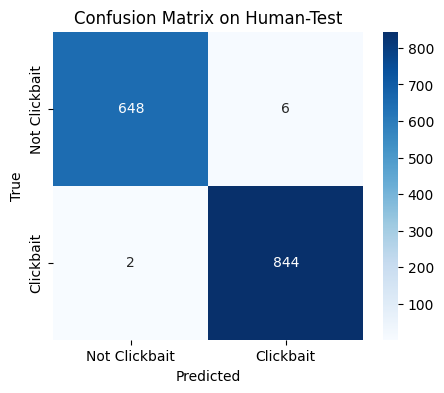

/tmp/ipython-input-3671076011.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics_to_plot.keys()), y=list(metrics_to_plot.values()), palette="viridis")


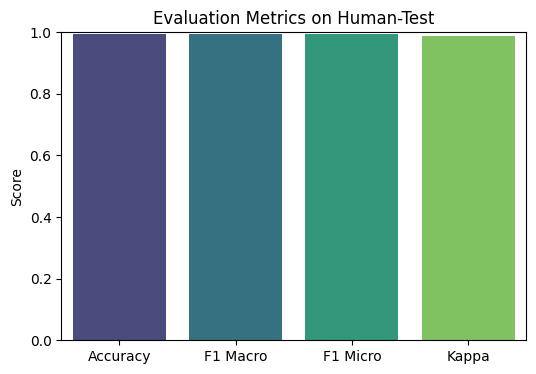

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix
y_true = raw_test.label_ids
y_pred = raw_test.predictions.argmax(axis=1)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Clickbait","Clickbait"], yticklabels=["Not Clickbait","Clickbait"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix on Human-Test")
plt.show()

# Bar plot for metrics
metrics_to_plot = {
    "Accuracy": test_metrics["accuracy"],
    "F1 Macro": test_metrics["f1_macro"],
    "F1 Micro": test_metrics["f1_micro"],
    "Kappa": test_metrics["kappa"]
}

plt.figure(figsize=(6,4))
sns.barplot(x=list(metrics_to_plot.keys()), y=list(metrics_to_plot.values()), palette="viridis")
plt.ylim(0,1)
plt.title("Evaluation Metrics on Human-Test")
plt.ylabel("Score")
plt.show()